In [121]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import joblib
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    f1_score, roc_auc_score, ConfusionMatrixDisplay, mean_squared_error
)
from scipy.special import gamma
from colorama import Fore, Style

warnings.filterwarnings('ignore')

os.makedirs('../results',exist_ok=True)
os.makedirs('../models',exist_ok=True)

data = pd.read_csv('../data/Heart_Disease.csv')
scaler = StandardScaler()
running_num = 10

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


**Defining a function that can let us save the results in a file**

In [122]:
def save_to_file(name, params, start_time, end_time, optimizer=None, y_pred=None, y_test=None, scaled=False):
    file = open(f"../results/{name}.txt", "a+")
    file.write(f'Running number: {running_num}\n')
    
    def format_time(seconds):
        if seconds >= 3600:
            return f"{seconds/3600:.2f} h"
        elif seconds >= 60:
            return f"{seconds/60:.2f} min"
        else:
            return f"{seconds:.2f} s"
        
    if scaled:
        file.write('SCALED\n')
    else: 
        file.write('NOT SCALED\n')
    
    if optimizer:
        file.write(f'Optimizer: {optimizer}\n')
    file.write(f"{params}\n--------------------------\n")
    
    if y_pred is not None and y_test is not None:
        auc = roc_auc_score(y_test, y_pred)
        cr = classification_report(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        file.write(f"Training Time: {format_time(end_time - start_time)} \n")
        file.write("Classification Report:\n")
        file.write(f"{cr}\n")
        file.write(f"MSE = {mse:.4f}\n")
        file.write(f"AUC = {auc:.4f}\n")

    file.write(f"\n--------------------------\n")
    file.close()

# Spliting the data


In [123]:
X = data.drop('target',axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [124]:
def train_evaluate_knn(model, params, st=0.0, et=0.0, optimizer=None, scaling=False):
    sns.set_theme(style='white')
    
    if scaling:
        print(Fore.GREEN + "Running KNN with scaling..." + Style.RESET_ALL)
        X_train_use, X_test_use = X_train_scaled, X_test_scaled
    else:
        print(Fore.GREEN + "Running KNN without scaling..." + Style.RESET_ALL)
        X_train_use ,X_test_use = X_train, X_test

    knn_model = model
    knn_model.fit(X_train_use, y_train)

    y_pred = knn_model.predict(X_test_use)
    # y_prob = knn_model.predict_proba(X_test_use)[:,1] # type: ignore

    acc = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    auc = roc_auc_score(y_test,y_pred)

    cv_acc = cross_val_score(knn_model,X_train_use, y_train, cv=5, scoring='accuracy').mean()
    cv_f1 = cross_val_score(knn_model,X_train_use, y_train, cv=5, scoring='f1').mean()
    cv_auc = cross_val_score(knn_model, X_train_use, y_train, cv=5, scoring='roc_auc').mean()

    clr = classification_report(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)

    print(f"\n{Fore.BLUE}Accuracy (Test): {acc:.4f} | CV: {cv_acc:.4f}")
    print(f"F1-Score (Test): {f1:.4f} | CV: {cv_f1:.4f}")
    print(f"AUC (Test): {auc:.4f} | CV-AUC: {cv_auc:.4f}")
    
    print("\nClassification Report:\n", clr, Style.RESET_ALL)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix -KNN {'Scaled' if scaling else 'Unscaled'}{' +' + optimizer if optimizer else ''}')
    plt.savefig(f'../results/cm_KNN_{'Scaled' if scaling else 'Unscaled'}{'_' + optimizer if optimizer else ''}_{running_num}.png', dpi=300)
    plt.close()

    save_to_file('KNN', params, st, et, optimizer, y_pred, y_test, scaling)
    return {
        'model': knn_model,
        'Accuracy':acc,
        'F1':f1,
        'AUC': auc,
        'CV_Acc':cv_acc,
        'CV_F1':cv_f1,
        'CV_AUC': cv_auc,
        'Confusion_matrix':cm,
        'Classification_report':clr,
    }

# Training and evaluating baseline KNN model

In [125]:
print("****** Results of the Baseline KNN Model ******")
knn = KNeighborsClassifier()

result_unscaled = train_evaluate_knn(knn,'default', scaling=False)
result_scaled = train_evaluate_knn(knn, 'default', scaling=True)

****** Results of the Baseline KNN Model ******
Running KNN without scaling...

Accuracy (Test): 0.7017 | CV: 0.7049
F1-Score (Test): 0.7280 | CV: 0.7255
AUC (Test): 0.6984 | CV-AUC: 0.7553

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.64      0.67       112
           1       0.70      0.75      0.73       126

    accuracy                           0.70       238
   macro avg       0.70      0.70      0.70       238
weighted avg       0.70      0.70      0.70       238
 
Running KNN with scaling...

Accuracy (Test): 0.8361 | CV: 0.8488
F1-Score (Test): 0.8494 | CV: 0.8575
AUC (Test): 0.8338 | CV-AUC: 0.9042

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.79      0.82       112
           1       0.83      0.87      0.85       126

    accuracy                           0.84       238
   macro avg       0.84      0.83      0.83       238
weighted avg       0.

# Finding Best Parameters using Grid Search

In [126]:
param_grid = {
    'n_neighbors': list(range(2, 31)),  
    'p': [1, 2, 3],  
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'hamming', 'cosine'],
    'weights': ['uniform', 'distance']
}

start = time.time()
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring='f1',  
    cv=5,
)

grid_search.fit(X_train, y_train)
end = time.time()

best_knn = grid_search.best_estimator_

result_GridSearch = train_evaluate_knn(best_knn, grid_search.best_params_, start, end, 'Grid Search', scaling=True)

Running KNN with scaling...

Accuracy (Test): 0.9244 | CV: 0.9023
F1-Score (Test): 0.9274 | CV: 0.9095
AUC (Test): 0.9251 | CV-AUC: 0.9591

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.92       112
           1       0.94      0.91      0.93       126

    accuracy                           0.92       238
   macro avg       0.92      0.93      0.92       238
weighted avg       0.92      0.92      0.92       238
 


# OOA Implementation (adapted from Octopus optimization Algorithm article)
### Levy Flight helper (Eq. 13-14 from article)

In [127]:
def levy_flight(dim, beta=1.5):
    numerator = gamma(1 + beta) * np.sin((np.pi * beta)/2)
    denomenator = gamma((1 + beta) /2) * beta * (2 ** ((beta-1) /2))
    sigma = (numerator / denomenator) ** (1/beta)
    u = np.random.normal(0, 1, dim)
    v = np.random.normal(0,1, dim)
    step = 0.01 * ((u * sigma) / (np.abs(v) ** (1/beta)))

    return step

In [128]:
def ooa_optimizer(obj_func, lb, ub, dim=2, N=30, max_iter=80, Nh=20, Ns=10, vr=3, ll=0.8, verbose=True):
    # np.random.seed(42)
    sns.set_theme('paper')  
    
    if Nh <= 0 or Ns < 0 or Nh + Ns > N:
        raise ValueError("Invalid Nh/Ns: require Nh>0, Ns>=0 and Nh+Ns <= N")

    # Initialize population
    pop = np.random.uniform(lb, ub, size=(N, dim))
    fitness = np.array([obj_func(ind) for ind in pop])

    # Deviding the population into hunters and scouts
    # each hunter has a head and 8 tentacles
    hunters = []
    for i in range(Nh):
        head = pop[i].copy()
        head_fit = fitness[i]
        
        tentacles = head + np.random.uniform(-ll, ll, size=(8, dim))
        tent_fits = np.array([obj_func(t) for t in tentacles])
        hunters.append({
            "head": head,
            "head_fit": head_fit,
            "tentacles": tentacles,
            "tent_fits": tent_fits
        })

    # Best global
    best_idx = np.argmin(fitness)
    best_pos = pop[best_idx].copy()
    best_fit = fitness[best_idx]

    history = [best_fit]

    for t in range(1, max_iter + 1):
        ld = vr * (1.0 - t / max_iter)  
        trans = (2 * np.random.rand() - 1) * ld
        
        # Update hunters and their tentacles
        for i, hunter in enumerate(hunters):
            head = hunter["head"]
            old_head = head.copy()
            # one tentacle retains previous head as short-term memory
            memory_idx = 0
            hunter["tentacles"][memory_idx] = old_head.copy()
            hunter["tent_fits"][memory_idx] = hunter["head_fit"]

            for j in range(8):
                tent = hunter["tentacles"][j].copy()
                
                closest_idx = np.argmin(np.linalg.norm(hunter["tentacles"] - best_pos, axis=1))
                closest_tent = hunter["tentacles"][closest_idx].copy()
                
                if abs(trans) < ll:
                    new_tent = tent + np.random.rand() * (best_pos - closest_tent) * levy_flight(dim)
                    
                else:
                    new_tent = hunter["head"] + np.random.rand() * (hunter["head"] - tent) * levy_flight(dim)

                new_tent = np.clip(new_tent, lb, ub)
                new_fit = obj_func(new_tent)

                if new_fit < hunter["tent_fits"][j]:
                    hunter["tentacles"][j] = new_tent
                    hunter["tent_fits"][j] = new_fit

            # modify head position to its optimal tentacle
            best_tent_idx = np.argmin(hunter["tent_fits"])
            if hunter["tent_fits"][best_tent_idx] < hunter["head_fit"]:
                hunter["head"] = hunter["tentacles"][best_tent_idx].copy()
                hunter["head_fit"] = hunter["tent_fits"][best_tent_idx]

            # update global best
            if hunter["head_fit"] < best_fit:
                best_fit = hunter["head_fit"]
                best_pos = hunter["head"].copy()

        
        hunter_heads = np.array([h["head"] for h in hunters])
        hunter_head_fits = np.array([h["head_fit"] for h in hunters])

        # choose Ns positions consisting of the best, the worst and Ns - 2 random positions from hunters
        best_h_idx = np.argmin(hunter_head_fits)
        worst_h_idx = np.argmax(hunter_head_fits)

        chosen_heads = []
        chosen_indices = []
        
        if Ns > 0:
            chosen_heads.append(hunter_heads[best_h_idx].copy())
            chosen_indices.append(best_h_idx)
            if Ns > 1:
                chosen_heads.append(hunter_heads[worst_h_idx].copy())
                chosen_indices.append(worst_h_idx)
            
            remaining = Ns - len(chosen_heads)
            if remaining > 0:
                pool = [i for i in range(len(hunters)) if i not in chosen_indices] # getting the rest of the hunters
                sel = list(np.random.choice(pool, size=remaining, replace=False)) # selecting randomly from them
                for s in sel:
                    chosen_heads.append(hunter_heads[s].copy())
                    chosen_indices.append(s)

            # create scouts based on chosen_heads 
            scouts = []
            for ch in chosen_heads:
                new_pos = ch + np.random.rand() * ld * (ub + lb - 2 * ch)
                new_pos = np.clip(new_pos, lb, ub)
                scouts.append(new_pos)

            for sc_pos, h_idx in zip(scouts, chosen_indices):
                sc_fit = obj_func(sc_pos)
                if sc_fit < hunters[h_idx]["head_fit"]:
                    # convert scout to hunter
                    hunters[h_idx]["head"] = sc_pos.copy()
                    hunters[h_idx]["head_fit"] = sc_fit
                    new_tentacles = np.random.rand(8, dim) * (sc_pos + ll) - (sc_pos - ll)
                    hunters[h_idx]["tentacles"] = np.clip(new_tentacles, lb, ub)
                    hunters[h_idx]["tent_fits"] = np.array([obj_func(t) for t in hunters[h_idx]["tentacles"]])

                    # update global best if needed
                    if sc_fit < best_fit:
                        best_fit = sc_fit
                        best_pos = sc_pos.copy()
                        
        history.append(best_fit)

        if verbose and t % 20 == 0:
            print(f"Iteration {t}: Best fitness = {best_fit:.4f}")


    plt.figure(figsize=(8,5))
    plt.plot(history)
    plt.xlabel('Iterations')
    plt.ylabel('Fitness Values (minimization)')
    plt.title(f'OOA fitness over {max_iter} iterations')
    plt.savefig(f'../results/OOA fitness over {max_iter} iterations_{running_num}.png', dpi=300)
    plt.show()

    return best_pos, best_fit

**Defining Objective Function**

In [129]:
metric_map = {1: 'euclidean', 2: 'manhattan', 3: 'chebyshev', 4:'minkowski', 5:'hamming', 6:'cosine'}
weight_map = {1: 'uniform', 2: 'distance'}

def knn_objective(params):
    k = int(np.clip(params[0],2,30))  
    p = np.clip(params[1],1,3)
    metric_idx = int(np.clip(params[2], 1, 6))
    weight_idx = int(np.clip(params[3], 1, 2))

    metric = metric_map[metric_idx]
    weights = weight_map[weight_idx]

    knn =KNeighborsClassifier(n_neighbors=k, p=p, metric=metric,weights=weights)  # type: ignore
    
    cv_acc = cross_val_score(knn, X_train_scaled, y_train,cv=5, scoring='accuracy').mean()

    return 1 - cv_acc # minimizing 

**Finding best parameters using OOA**

In [ ]:
lb = np.array([1, 1, 1, 1])
ub = np.array([30, 3, 3, 2])
dim = 4

print("\n**** OOA Optimazation (CV based) ****")
start = time.time()
best_params, best_cv_acc = ooa_optimizer(knn_objective, lb, ub, dim, N=30, max_iter=80) 
end = time.time()
best_k, best_p, best_metric_idx, best_weight_idx  = int(best_params[0]), best_params[1], int(best_params[2]), int(best_params[3])

best_metric = metric_map[best_metric_idx]
best_weight = weight_map[best_weight_idx]

print(f"\nBest OOA Params : k = {best_k}, p = {best_p:.2f}, metric = {best_metric}, weights = {best_weight}")
print(f"Min OOA CV Accuracy:{best_cv_acc:.4f}")


**** OOA Optimazation (CV based) ****
Iteration 20: Best fitness = 0.0945
Iteration 40: Best fitness = 0.0945


In [ ]:
knn = KNeighborsClassifier(n_neighbors=best_k, p=best_p, metric=best_metric,weights=best_weight) # type: ignore

result_OOA = train_evaluate_knn(knn, f'n_neighbors: {best_k}, p: {best_p:.2f}, metric: {best_metric}, weights: {best_weight}', start, end, 'OOA', scaling=True)

Running KNN with scaling...

Accuracy (Test): 0.9538 | CV: 0.9065
F1-Score (Test): 0.9562 | CV: 0.9124
AUC (Test): 0.9539 | CV-AUC: 0.9556

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       112
           1       0.96      0.95      0.96       126

    accuracy                           0.95       238
   macro avg       0.95      0.95      0.95       238
weighted avg       0.95      0.95      0.95       238
 


In [ ]:
train_acc = accuracy_score(y_train, result_OOA['model'].predict(X_train_scaled))
print(f"Overfit checker : Train acc={train_acc:.4f}  vs Test= {result_OOA['Accuracy']:.4f}, Diff: {train_acc - result_OOA['Accuracy']} (Diff < 0.05 -->ok)")

Overfit checker : Train acc=1.0000  vs Test= 0.9538, Diff: 0.04621848739495793 (Diff < 0.05 -->ok)


**Finding Best Parameters using IFOX**

In [ ]:
import IFOX
from mealpy import FloatVar

problem = {
    "bounds": FloatVar(lb=[2, 1, 1, 1], ub=[30, 3, 6, 2]), #type: ignore
    "obj_func": knn_objective,
    "minmax": "min",
    "name": "KNN_Optimization",
    "log_to": "console",
}

start = time.time()
ifox = IFOX.IFOX(epoch=80, pop_size=30, name = 'IFOX') # type: ignore
best_solution_ifox = ifox.solve(problem)
end = time.time()

print(f"Best parameters: {best_solution_ifox.solution}")
print(f"Best fitness: {best_solution_ifox.target.fitness}")

2025/12/09 05:22:05 PM, INFO, IFOX.IFOX: Solving single objective optimization problem.
2025/12/09 05:22:14 PM, INFO, IFOX.IFOX: >>>Problem: KNN_Optimization, Epoch: 1, Current best: 0.09663268117938828, Global best: 0.09663268117938828, Runtime: 6.79844 seconds
2025/12/09 05:22:22 PM, INFO, IFOX.IFOX: >>>Problem: KNN_Optimization, Epoch: 2, Current best: 0.09138054560484987, Global best: 0.09138054560484987, Runtime: 7.87226 seconds
2025/12/09 05:22:27 PM, INFO, IFOX.IFOX: >>>Problem: KNN_Optimization, Epoch: 3, Current best: 0.09138054560484987, Global best: 0.09138054560484987, Runtime: 4.61461 seconds
2025/12/09 05:22:32 PM, INFO, IFOX.IFOX: >>>Problem: KNN_Optimization, Epoch: 4, Current best: 0.09138054560484987, Global best: 0.09138054560484987, Runtime: 5.01427 seconds
2025/12/09 05:22:37 PM, INFO, IFOX.IFOX: >>>Problem: KNN_Optimization, Epoch: 5, Current best: 0.09138054560484987, Global best: 0.09138054560484987, Runtime: 4.57357 seconds
2025/12/09 05:22:41 PM, INFO, IFOX.IF

Best parameters: [9.57027702 2.25635611 5.08379078 2.        ]
Best fitness: 0.09138054560484987


**Fitness Evaluation of IFOX**

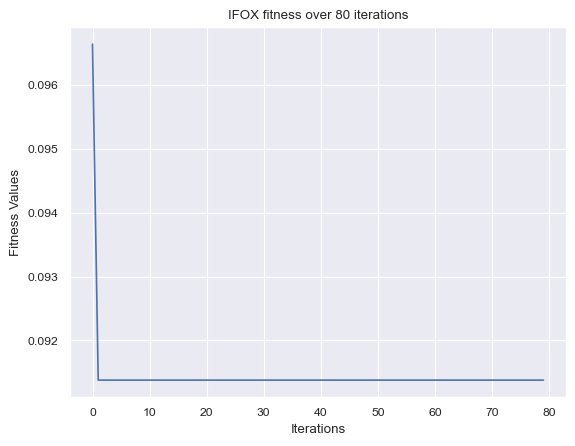

In [ ]:
sns.set_theme('paper')
ifox.history.save_global_best_fitness_chart(title='IFOX fitness over 80 iterations', x_label='Iterations', y_label='Fitness Values', filename=f'IFOX fitness over 80 iterations_{running_num}') #type: ignore

In [ ]:
best_k_ifox, best_p_ifox, best_metric_idx_ifox, best_weight_idx_ifox = int(best_solution_ifox.solution[0]), best_solution_ifox.solution[1], int(best_solution_ifox.solution[2]), int(best_solution_ifox.solution[3])

best_metric_ifox = metric_map[best_metric_idx]
best_weight_ifox = weight_map[best_weight_idx]

knn = KNeighborsClassifier(n_neighbors=best_k_ifox, p=best_p_ifox, metric=best_metric_ifox, weights=best_weight_ifox) # type: ignore
result_IFOX = train_evaluate_knn(knn, f'n_neighbors: {best_k_ifox}, p: {best_p_ifox:.2f}, metric: {best_metric_ifox}, weights: {best_weight_ifox}', start, end, 'IFOX', scaling=True)

Running KNN with scaling...

Accuracy (Test): 0.9454 | CV: 0.8992
F1-Score (Test): 0.9482 | CV: 0.9048
AUC (Test): 0.9454 | CV-AUC: 0.9525

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94       112
           1       0.95      0.94      0.95       126

    accuracy                           0.95       238
   macro avg       0.95      0.95      0.95       238
weighted avg       0.95      0.95      0.95       238
 


# Final Results

**** PERFORMANCE RESULTS COMPARISON: ****

                   Model  Test Acc  Test F1  Test AUC  CV Acc   CV F1  CV AUC
0           KNN Unscaled    0.7017   0.7280    0.6984  0.7049  0.7255  0.7553
1             KNN Scaled    0.8361   0.8494    0.8338  0.8488  0.8575  0.9042
2  Grid Search optimized    0.9244   0.9274    0.9251  0.9023  0.9095  0.9591
3         IFOX optimized    0.9454   0.9482    0.9454  0.8992  0.9048  0.9525
4          OOA optimized    0.9538   0.9562    0.9539  0.9065  0.9124  0.9556

**** Grid Search Classification Report: ****

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       112
           1       0.94      0.91      0.93       126

    accuracy                           0.92       238
   macro avg       0.92      0.93      0.92       238
weighted avg       0.92      0.92      0.92       238


**** IFOX Classification Report: ****

              precision    recall  f1-score   support

           0       0

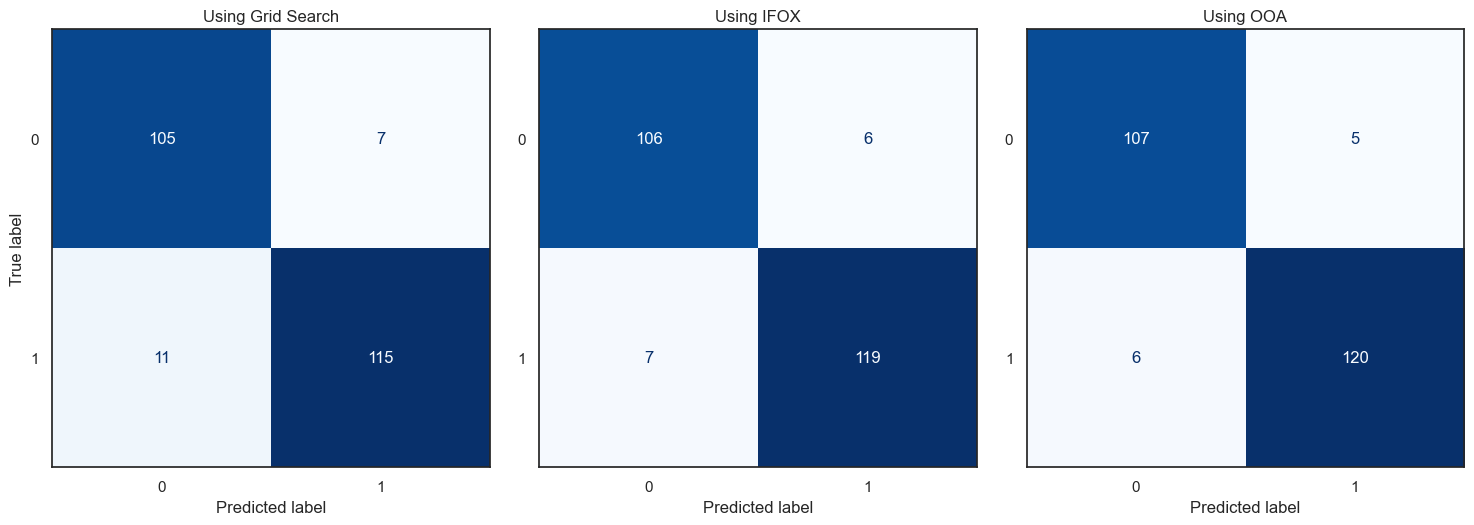

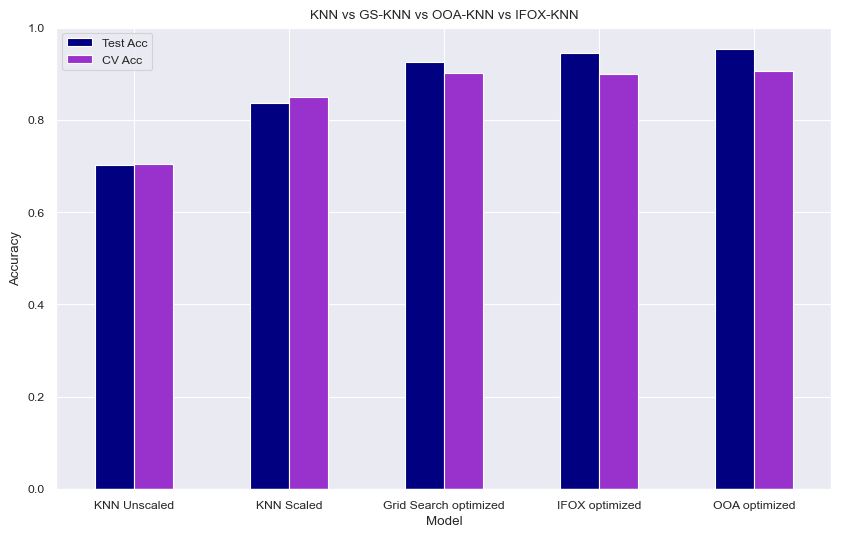

In [ ]:
print(Fore.MAGENTA + '**** PERFORMANCE RESULTS COMPARISON: ****\n' + Style.RESET_ALL)

comparison_data = {
    'Model': ['KNN Unscaled','KNN Scaled', 'Grid Search optimized', 'IFOX optimized', 'OOA optimized'],
    'Test Acc': [result_unscaled['Accuracy'], result_scaled['Accuracy'], result_GridSearch['Accuracy'], result_IFOX['Accuracy'], result_OOA['Accuracy']],
    'Test F1': [result_unscaled['F1'], result_scaled['F1'], result_GridSearch['F1'], result_IFOX['F1'], result_OOA['F1']],
    'Test AUC':[result_unscaled['AUC'], result_scaled['AUC'], result_GridSearch['AUC'], result_IFOX['AUC'], result_OOA['AUC']],
    'CV Acc': [result_unscaled['CV_Acc'], result_scaled['CV_Acc'], result_GridSearch['CV_Acc'], result_IFOX['CV_Acc'], result_OOA['CV_Acc']],
    'CV F1': [result_unscaled['CV_F1'], result_scaled['CV_F1'], result_GridSearch['CV_F1'], result_IFOX['CV_F1'], result_OOA['CV_F1']],
    'CV AUC':[result_unscaled['CV_AUC'], result_scaled['CV_AUC'], result_GridSearch['CV_AUC'], result_IFOX['CV_AUC'], result_OOA['CV_AUC']]
}

comparision = pd.DataFrame(comparison_data)
print(f'{Fore.BLUE}{comparision.round(4)}{Style.RESET_ALL}')

file = open('results.txt', 'a+')
file.write(f'\n\nNumber of Runs: {running_num}\n')
file.write('**** PERFORMANCE RESULTS COMPARISON: ****\n')
file.write(comparision.to_string())
file.write('\n')
file.write('='*100)
file.write('\n')
file.close()

print(Fore.MAGENTA + '\n**** Grid Search Classification Report: ****\n' + Style.RESET_ALL)
print(Fore.BLUE + result_GridSearch['Classification_report'] + Style.RESET_ALL)

print(Fore.MAGENTA + '\n**** IFOX Classification Report: ****\n' + Style.RESET_ALL)
print(Fore.BLUE + result_IFOX['Classification_report'] + Style.RESET_ALL)

print(Fore.MAGENTA + '\n**** OOA Classification Report: ****\n' + Style.RESET_ALL)
print(Fore.BLUE + result_OOA['Classification_report'] + Style.RESET_ALL)


sns.set_theme(style='white')
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

cms = [result_GridSearch['Confusion_matrix'],
       result_IFOX['Confusion_matrix'],
       result_OOA['Confusion_matrix']]

titles = ['Using Grid Search', 'Using IFOX', 'Using OOA']

for i, (ax, cm, title) in enumerate(zip(axes, cms, titles)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', ax=ax, colorbar=False)
    ax.set_title(f'{title}')
    
    if i > 0:
        ax.set_ylabel('')
        

plt.tight_layout()
plt.savefig(f'../results/cm_comparison_{running_num}.png', dpi=300)
plt.show()

sns.set_theme('paper')
comparision.set_index('Model')[['Test Acc','CV Acc']].plot(kind='bar', figsize=(10,6), color=['navy', 'darkorchid'])
plt.title('KNN vs GS-KNN vs OOA-KNN vs IFOX-KNN')
plt.ylabel('Accuracy')
plt.xticks(rotation=0)
plt.legend()
plt.savefig(f'../results/Acc_comparison_{running_num}.png', dpi=300)
plt.show()

In [ ]:
joblib.dump(result_OOA['model'], f'../models/ooa_knn_model_{running_num}.joblib')

['../models/ooa_knn_model_9.joblib']